Attempt to create a self consistent solution to the F-layer question!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools
%matplotlib inline

import scipy.optimize as spo
import boundary_layer
import feo_thermodynamics as feot

Pr =  0.09075  Sc =  999.9999999999999


In [2]:
# We will use PREM for pressure, gravity etc.
import sys
sys.path.append('/Users/andrewwalker/Code/prem4derg')
import earth_model
prem = earth_model.Prem()

In [3]:
def setup_flayer_functions(r_icb, r_cmb, r_flayer_top, gamma, delta_t_icb, xfe_adiabatic, xfe_icb):
    """
    This defines the radial functions we are going to need to model the f-layer
    
    Our input parameters are the (total) oxygen content at the top and bottom of 
    the layer, the subadiabatic cooling through the layer, a value for gamma
    for the adiabatic mantle and a thickness of the layer. We first uuse this 
    to find the liquidus temperature at the top of the F-layer. We then requier
    the CMB temperature to generate an adiabat that intersects the liquidus at the
    top of the f-layer.
    
    Arguments are:
    
    r_icb: ICB radius in m
    r_cmb: core mantle boundary radius in m
    r_flayer_top: radius of the top of the f-layer in m
    gamma: grunisen parameter for adiabatic mantle, dimensionless (1.5 is a typical value)
    delta_t_icb: subadiabatic temperature depression at the ICB in K, 10 K is a sensible value
    xfe_adiabatic: oxygen content (as mol frac Fe) of the adiabatic mantle (and top of the F-layer)
                    8-17 mol % O (i.e. 0.92-0.83) are sensible values
    xfe_icb: oxygen content (as mol frac Fe) at the bottom of the F-layer. NB: this is the total oxygen 
             content. As O partititons into the liquid the liquid will be enriched. 
    
    We end up returning a functions that can give the total oxygen content as a function
    of radius, the temperature as a function of radius, and the pressure (from PREM) as
    a function of radius. In the F-layer we assume linear temperature and composition
    profiles. These functions are (numpy) vectorized and take the radii in m. 
    """
    # First find the liquidus temperature at the top of the F-layer... we know P (from PREM)
    # and X (from our input). NB: my PREM module works in km and does not like vector input.
    # This is quite slow and could be optimised by avoiding the double brentq calls!
    tl_top_flayer = feot.find_liquidus(xfe_adiabatic, prem.pressure(radius_top_flayer/1000.0))
    print("Liquidus temperature at top of F-layer is", tl_top_flayer, "K")
    
    # Now we need to work out the adiabatic temperature profile that intersects the liquidus 
    # at the top of the F-layer. 
    rho_cmb = prem.density((radius_cmb-0.1)/1000.0) # -0.1 for core, not mantle rho
    rho_top_flayer = prem.density(radius_top_flayer/1000.0)
    def _t_error_top_flayer(tcmb):
        """
        For a given CMB temperature, calculate the difference between the temperature
        at the top of the f-layer and the liquidus temperature. We'll need to set 
        tcmb such that this is zero!
        """
        adabat_t_top_flayer = tcmb * (rho_top_flayer/rho_cmb)**gamma
        t_error = adabat_t_top_flayer - tl_top_flayer
        return t_error
    t_cmb = spo.brentq(_t_error_top_flayer, 1000, 8000)
    
    print("Temperature CMB is", t_cmb, "K")
    
    # We can now build our function to give the adiabatic temperature
    rho_icb = prem.density(radius_inner_core/1000.0)
    adabat_t_top_flayer = t_cmb * (rho_top_flayer/rho_cmb)**gamma
    adabat_icb = t_cmb * (rho_icb/rho_cmb)**gamma
    @np.vectorize
    def adiabatic_temperature_function(r):
        temp = t_cmb * (prem.density(r/1000.0)/rho_cmb)**gamma
        return temp
    
    # And the function to give the 'real' temperature (including a subadiabatic layer)
    # We'll base temperature on an adiabat (temperature at top of F-layer)
    # and then assume it's linear to a subadiabatic ICB temperature
    # Do note that we cannot use the ICB as a tie point as (1) the F-layer
    # is not adiabatic and (2) we are not assuming phase equilibrium at the ICB
    # which means the ICB need not be at any particular melting temperature. 
    # This is an important point (probably the most important point if we introduce
    # non-equilibrium processes).
    temperature_icb = adabat_icb - delta_t_icb
    @np.vectorize
    def temperature_function(r):
        if r > radius_top_flayer:
            temp = t_cmb * (prem.density(r/1000.0)/rho_cmb)**gamma
        else: # Will give value inside inner core, but we may need that for IVP solver...
            temp = temperature_icb + (r - r_icb)*(
                (adabat_t_top_flayer-temperature_icb)/(r_flayer_top-r_icb))
        return temp
    

    # Finally, a function to give the composition everywhere
    @np.vectorize
    def composition_function(r):
        if r > radius_top_flayer:
            xfe = xfe_adiabatic
        else:
            xfe = xfe_icb + (r - r_icb)*(
                (xfe_adiabatic-xfe_icb)/(r_flayer_top-r_icb))
        return xfe
    
    @np.vectorize           
    def pressure_function(r):
        return prem.pressure(r/1000.0)
    
    @np.vectorize
    def gravity_function(r):
        return prem.gravity(r/1000.0)
    
    return temperature_function, adiabatic_temperature_function, composition_function, pressure_function, gravity_function






In [4]:
# F-layer setup
radius_inner_core = 1221.5e3
radius_top_flayer = radius_inner_core + 200.0e3
radius_cmb = 3480.0e3
gamma = 1.5

# IVP defaults
start_time = 0 # s
max_time = 100000000000 # s
rtot = 1.0 # initial box radius

# Physical properties
initial_particle_size = 1.0E-10 # initial radius, m - should be critical radius for nucleation
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

tfunc, atfunc, xfunc, pfunc, gfunc = setup_flayer_functions(radius_inner_core, radius_cmb, radius_top_flayer, 
                                                    gamma, 10.0, 0.92, 0.92)

Liquidus temperature at top of F-layer is 5698.941318305444 K
Temperature CMB is 4242.543317870397 K


In [5]:
print("Pressure at ICB:", prem.pressure(radius_inner_core/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(radius_top_flayer/1000.0), "GPa")
print("g at ICB:", prem.gravity(radius_inner_core/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(radius_top_flayer/1000.0), "m/s**2")

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


In [6]:
rs = np.linspace(radius_inner_core, radius_inner_core+500.0E3)
ts = tfunc(rs)
ats = atfunc(rs)
ps = pfunc(rs)
xs = xfunc(rs)
tl = feot.find_liquidus(xs, ps)

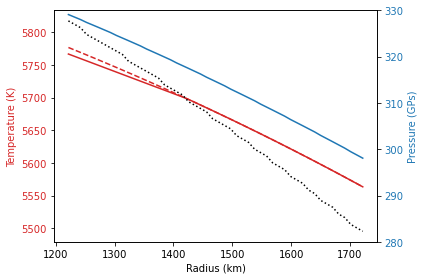

In [7]:


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ts, color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, ps, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([280, 330])

fig.tight_layout()  
plt.show()


## Equilibrium calculation

(This is really easy...)

In [8]:
feot.volume_fraction_solid(xs, ps, ts)

array([0.08457566, 0.08209002, 0.07958301, 0.06902238, 0.06641458,
       0.06378388, 0.06112998, 0.05845259, 0.05575122, 0.05302592,
       0.04166147, 0.03882261, 0.03595786, 0.03306674, 0.03014913,
       0.02720455, 0.01503412, 0.01196271, 0.00886222, 0.00573231,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [9]:
x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, ps, ts)
x_lq

array([0.91212214, 0.91237419, 0.91262704, 0.9136778 , 0.91393351,
       0.91419003, 0.91444738, 0.91470554, 0.91496453, 0.91522434,
       0.91629226, 0.91655502, 0.91681863, 0.91708308, 0.91734839,
       0.91761454, 0.91869797, 0.91896716, 0.91923722, 0.91950816,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ])

In [10]:
liquid_density, solid_mixture_density, fe_liquid_density, fe_hpc_density, \
           feo_liquid_density, feo_solid_density = feot.densities(xs, ps, ts)

In [11]:
def bulk_modulous(x, p, t):
    """
    Calculate the bulk modulus of Fe, FeO and the liquid
    
    This works by taking the derivative of the (high temperature)
    volume with respect to pressure at fixed temperature and composition.
    """
    # See notes in labook. Not as easy as it looks. Need to get to Ks (not Kt)
    # and anyway, model does the wrong thing. Avoid?
    return None

## Non-equilibrium calculation

In [12]:
# Start 10m inside layer.
start_radius = radius_top_flayer-10.0

sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                       start_radius, xfunc, rtot, tfunc, pfunc,
                                                       dl, k0, gfunc, mu, radius_inner_core)

print('Finished because: ', sol.message)
# Interpolate solution (using 5th order polynomial interpolation)
times = np.linspace(sol.sol.ts[0], sol.sol.ts[-1], 500)
rps = sol.sol(times)[0]
lps = sol.sol(times)[1]



Finished because:  A termination event occurred.


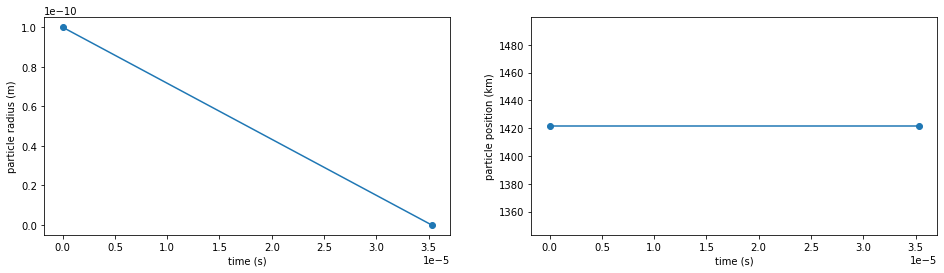

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(times, rps)
ax[0].scatter(sol.t, sol.y[0])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('particle radius (m)')

ax[1].plot(times, lps/1000)
ax[1].scatter(sol.t, sol.y[1]/1000)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('particle position (km)')
plt.show()

In [14]:
# Trey 10 km inside layer...

start_radius = radius_top_flayer-10000.0


sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                       start_radius, xfunc, rtot, tfunc, pfunc,
                                                       dl, k0, gfunc, mu, radius_inner_core)

print('Finished because: ', sol.message)
# Interpolate solution (using 5th order polynomial interpolation)
times = np.linspace(sol.sol.ts[0], sol.sol.ts[-1], 500)
rps = sol.sol(times)[0]
lps = sol.sol(times)[1]

Finished because:  A termination event occurred.


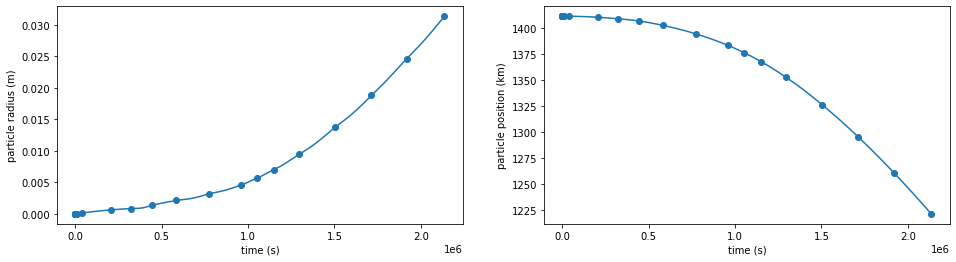

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(times, rps)
ax[0].scatter(sol.t, sol.y[0])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('particle radius (m)')

ax[1].plot(times, lps/1000)
ax[1].scatter(sol.t, sol.y[1]/1000)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('particle position (km)')
plt.show()

In [16]:
# Start off with five depths - this is where we start the particles for the calculation of volume fraction
# solid etc. We can add more later
integration_depths = np.linspace(radius_inner_core+1000.0, radius_top_flayer-1000.0, 5)
# And some depths where we perform the calculation. This is where we find out the volume fraction solid etc.
# We'll also always do this at the ICB
analysis_depths = np.linspace(radius_inner_core+500.0, radius_top_flayer-1500.0, 5)
print(integration_depths)


# We need to run the IVP solver for each integration depth but with the analisis depths set as
# non-terminal events.

[1222500. 1272000. 1321500. 1371000. 1420500.]


In [17]:
start_radius = radius_top_flayer-10000.0


sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                       start_radius, xfunc, rtot, tfunc, pfunc,
                                                       dl, k0, gfunc, mu, radius_inner_core, analysis_depths)

In [18]:
sol.t_events

[array([2136336.21047674]),
 array([], dtype=float64),
 array([2133707.45728158]),
 array([1859312.63801345]),
 array([1543070.41351987]),
 array([1122062.33053018]),
 array([], dtype=float64)]

In [19]:
def report_all_solution_events(sol):
    """
    Print out what happend to a single ODE IVP falling calculation
    
    We are careful to check when things don't happen. And check for 
    double crossings of depths (say we have upward falling) but just
    treat that as an error for now.
    """
    if not sol.t_events[0].size > 0:
        print('did not reach icb')
    else:
        assert sol.t_events[0].size == 1, "Double crossing detected"
        print('icb at t = ', sol.t_events[0][0], 's, with particle radius = ', sol.y_events[0][0][0])
    
    if not sol.t_events[1].size > 0:
        print('did not dissolve')
    else:
        print('particle dissolved at t = ', sol.t_events[1][0], 's')
    for i, r in enumerate(analysis_depths):
        if sol.t_events[i+2].size > 0:
            assert sol.t_events[i+2].size == 1, "Double crossing detected"
            print("reached r = ", r, 'm at t = ', sol.t_events[i+2][0], 's, with particle radius = ', sol.y_events[i+2][0][0])
        else:
            print('did not reach r = ', r, 'm')
    print("")
            
report_all_solution_events(sol)

icb at t =  2136336.210476739 s, with particle radius =  0.03136881475431338
did not dissolve
reached r =  1222000.0 m at t =  2133707.457281578 s, with particle radius =  0.03127847721602102
reached r =  1271500.0 m at t =  1859312.6380134537 s, with particle radius =  0.022878754341805585
reached r =  1321000.0 m at t =  1543070.4135198698 s, with particle radius =  0.014558324725396863
reached r =  1370500.0 m at t =  1122062.3305301834 s, with particle radius =  0.006656871974684815
did not reach r =  1420000.0 m



### The particle density and optimisation of the interaction volume

Thus far we have treated the 'interaction volume' around the falling particles as an
externally imposed parameter. However, we would like the composition (in terms of 
oxygen content) of the F-layer to be conserved. While the composition inside each
interaction volume is conserved by construction, we also need to ensure that these
volumes do not intersect. If this is not the case we end up with regions of the
F-layer where the composition is doubly (and inconsistently) defined. If this is
not the case, the total layer composition is constrained by construction and it is
easy to evaluate the average liquid composition by noting its volume is just the
volume of the layer with the volume of solid particles removed, and that all the 
oxygen is in the liquid. The problem with this line of attack is that the growth
rate of the falling particles, and thus their spacing, depends on the size of the
interaction region. Furthermore, if the interaction volumes don't fill space we
will have regions of the layer between interaction volumes with reduced oxygen
content compared to the interaction volumes. It thus seems that our interaction
volumes should fill space and we end up with no flux boundary conditions halfway
between each growing particle. In order to set this up we need to self consistently
solve the falling particles ODEs using the following algorithem:

1. Set an initial guess for the interaction volume radius
2. Solve ODEs 
3. Calculate spacing between particles
4. If spacing does not equal radius update radius and repeate from 2 otherwise
5. Evaluate mean oxygen content of liquid

Note that for many falling particles nucleating throughout the layer the volume
radius will need to change through the layer (we may expect it will decrease as the
number density of particles increases downwards). We thus need to set the interaction
volume radius as a parameterised function (analogously to the temperature).

Given the above, we need a way to evaluate the number density of particles at any
depth in the F-layer. The following uses the (rubbish) notation from the inner core
growth notebook to describe how this is done.

From a single solution to the IVP...

The information we have is the nuclation rate, $\mathscr{N}(z_n)$, and relationship between
the particle position $z_p(z_n)$ with time, $t$. Both are functions of the nuclation height
$z_n$.

At some depth, $z$, the spacing, $s$, between particles nuclating in a given volume, $V_n$, at depth
$z_n$ is given by the product of the recprical of the nuclation rate (the spacing in time between
the particles), the nucliation volume, and the velocity of the falling particles.

$$\tau_v = \frac{1}{2N}$$ mean time for nucleation event in volume V [s m^3]
$$\tau = \frac{\tau_v }{V_n}$$ time in unit volume [s]. Time between nucleation events

Draw diagram showing that spacing is velocity of falling times delta t (which is tau)

Or just use interpolated time - position for particle that nuclated tau betfore and tau after
and take the mean of the two spacings.  FIX THIS:

$$s(z, z_n) = \left. \frac{d z_p(z_n)}{dt} \right|_z \frac{1}{2\mathscr{N}(z_n)}$$

Then 1/s is the number density of particles from z_n at z. 

Intergrate the number density over z_n to get the total number density of all particles at z

How to deal with lat and lon... this is where V_n comes in above? V_n should tesselate. 

So we **think** we just choose V_n as a shell thickenss multiplied by a meter sqyared. And integrate over the shells...


The factor of $\frac{1}{2}$ is to convert the rate at which particles reach the critical radius (if that's what
we are calling the nuclation rate) into a waiting time (in s.m^3). This product is in units
of m. The solution to the IVP allows us to calculate $\left. \frac{d z_p(z_n)}{dt}\right|_z$ at any
(pre-chosen) value of $z$ and for any given $z_n$.

The total number of 



In [40]:
def partial_particle_density(ivp_solution, event_index, nucleation_rate, nucleation_volume, verbose=True):
    """
    Evaluate the 'partial' particle density at a given radius given a single solution to the IVP
    

    ivp_solution: solution object for IVP. Must have events attached. Must also have dense 
            output (i.e. a smooth interpolator) attached
    event_index: index into list of events in ivp_solution where analysis is to be perfomed. 
            This must correspond to the particle crossing the depth of interest and a sutible
            'event' must thus be attached to the IVP solution object. The event need not have
            been triggered (e.g. the particles could dissolve before reaching the radius of
            interest). 
    nucleation_rate: the rate of nucleation for the radius corresponding to t=0 for the IVP
            This is where the particles we are forming before they fall through our radius
            of interest (in particles per m^3 per s).
    nucleation_volume: the volume where nucleation takes place (in m^3)
    
    Returns the partial particle density in particles per m^3 nucleating in the volume
    represented by the start of the IVP. This must be integrated to find the total density.
    (See notes in the notebook re. statistical meaning of this given CNT!)
    """
    # Calculate the average time between nucleation events, this is the 'waiting time'
    # of Davies et al. 2019 and includes a factor of 1/2 to account for half of the 
    # particles reaching r_c then dissolving.
    tau = 1.0/(2.0*nucleation_rate*nucleation_volume)
    
    # Find the time where a particle that nucleated at t=0 reached the radius of interest
    # by searching through the IVP events. This cannot be the first (hit ICB) or second
    # (dissolved) event. We need to check even if it did dissolve as that could be below the
    # radius of interest.
    assert event_index > 1, "Cannot processes hit ICB or dissolved data"
    if ivp_solution.t_events[event_index].size > 0:
        assert sol.t_events[event_index].size == 1, "Double crossing detected"
        # NB: solution y_events indexed by event, then a list of times where the event is
        # seen (we want the first one - index 0) then a list of ys (i.e. particle radius, position)
        # and want the position which is index 1 
        analysis_radius = sol.y_events[event_index][0][1]
        analysis_time = sol.t_events[event_index][0]
        # We'll take the distances between this particle (nucleated at t=0) and the
        # one before (nucleated at t = -tau) and the one after (t = tau). Because we 
        # have a steady state solution the whole IVP solution is just shifted in time
        # so we can do the analysis from just this solution and use the dense output
        # to get the distance
        assert sol.sol(analysis_time)[1] == analysis_radius, "event / interpolator missmatch"
        if (analysis_time - tau) < 0.0:
            print("cannot process if next particle has yet to form")
            return 0.0
        if (analysis_time + tau) > sol.t[-1]:
            print("cannot process if previous particle has gone")
            return 0.0
        distance_below = analysis_radius - sol.sol(analysis_time + tau)[1]
        distance_above = sol.sol(analysis_time - tau)[1] - analysis_radius
        partial_density = 1.0 / (0.5 * (distance_below + distance_above)) # /m^3 - see notebook!
        if verbose:
            print("Partial density calculation at r = ", analysis_radius, "m")
            print("At time t = ", analysis_time, "s, and tau = ", tau, "s")
            print("Previous particle is", distance_below, "m below, next particle is", distance_above, "m above")
            print("Partial particle densituy is", partial_density, "particles / m^3")     
    else:
        # No particles at this depth (above nucleation depth or dissolved)
        # partial density is zero
        partial_density = 0.0
        if verbose:
            print("No event data (e.g. dissolved) so partical density is zero")
        
    return partial_density


In [41]:
# Does it work? - won't work if particles are too far apart compared to layer thickness!
partial_particle_density(sol, 3, 1.0E-13, 1000.0**3)

Partial density calculation at r =  1271500.0 m
At time t =  1859312.6380134537 s, and tau =  5000.0 s
Previous particle is 854.9648934870493 m below, next particle is 852.8800019402988 m above
Partial particle densituy is 0.001171066532654622 particles / m^3


0.001171066532654622

### The actual integration

In [50]:
secinMyr = 60.0*60.0*24.0*365.0*1000000

def integrate_snow_zone(analysis_depths, integration_depths, nucleation_rates):
    # FIXME: other parameters should be arguments
    solutions = []
    for int_depth in integration_depths:
        print("Starting ODE IVP solver for nuclation at", int_depth)
        sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                       int_depth, xfunc, rtot, tfunc, pfunc,
                                                       dl, k0, gfunc, mu, radius_inner_core, analysis_depths)
        assert sol.success, "No ODE solution found!"
        report_all_solution_events(sol)
        solutions.append(sol)
        
    print("ODE solved for all nuclation depths... calculating integrals over nuclation depth for particle density")
    particle_densities = np.zeros_like(analysis_depths)
    for i, analysis_r in enumerate(analysis_depths):
        analysis_index = i + 2
        # Particle density at this depth is 'just' the partial density
        # (density from nucleation depth) integrated over nuclation depths
        # It's okay to integrate nuc depths below int depth as this will
        # return zero density. This is a 1D integral (see notebook)
        partial_densities = np.zeros_like(integration_depths)
        for j, int_r in enumerate(integration_depths):
            # Skip if this will be zero - avoid noise
            if analysis_r > int_r:
                partial_densities[j] = 0.0
                next
                
            nuc_rate = nucleation_rates[j]
            nuc_area = 1000.0*1000.0
            if j == 0:
                # Innermost layer
                nuc_vol = nuc_area * (integration_depths[0] + 0.5 * (
                                      integration_depths[1] - integration_depths[0])
                                     ) - radius_inner_core 
            elif (j + 1) == integration_depths.size:
                # Outermost layer
                nuc_vol = nuc_area * radius_top_flayer - (integration_depths[-2] + 0.5 * (
                                      integration_depths[-1] - integration_depths[-2])
                                     )
            else:
                nuc_vol = nuc_area * ((integration_depths[j] + 0.5 * (
                                      integration_depths[j+1] - integration_depths[j]))
                                  - (integration_depths[j-1] + 0.5 * (
                                      integration_depths[j] - integration_depths[j-1])
                                    ))
            print("\nPartial density calc for i = ", i, "and j = ", j, "nuc_rate = ", nuc_rate, "nuc_vol = ", nuc_vol)
            print("Analysis r = ", analysis_r, "int r = ", int_r)
            partial_densities[j] = partial_particle_density(solutions[j], analysis_index, 
                                                            nuc_rate, nuc_vol)
        particle_density = np.trapz(partial_densities, integration_depths) / nuc_area # See units note...
        print("\nTotal particle density at r = ", analysis_r, "is", particle_density, "particles per m^3\n")
        particle_densities[i] = particle_density
        
    for rad, rho in zip(analysis_depths, particle_densities):
        print("Ar r =", rad, "m, particle density = ", rho)
    
    print("\nODE solved for all nuclation depths... calculating integrals over nuclation depth for inner core growth")
    
    # IC growth rate should be okay
    # We build up an array of solid volume as a function
    # of nuc depth and integrate
    particle_volumes = np.zeros_like(nucleation_rates)
    for i, sol in enumerate(solutions):
        if not sol.t_events[0].size > 0:
            # Disolved before reaching ICB
            p_radius = 0.0
            particle_volumes[i] = 0.0
        elif sol.t_events[0].size == 1:
            # Particle reached ICB exactly once
            p_radius = sol.y_events[0][0][0]
            particle_volumes[i] = 4/3 * np.pi * p_radius**3
        else:
            # Impossible multiple crossing of ICB
            raise NotImplementedError
            
    area_icb = 4.0 * np.pi * radius_inner_core**2
    growth_rate = np.trapz(particle_volumes * nucleation_rates * integration_depths**2 * 4.0 * np.pi, 
                           integration_depths) / area_icb
    
    print("Inner core growth rate:", growth_rate, "m/s")
    print("Inner core growth rate:", growth_rate/1000 * secinMyr, "km/Myr")
    
    


In [51]:
# Start off with five depths - this is where we start the particles for the calculation of volume fraction
# solid etc. We can add more later

# I have played with the number of points in the integration with the following results
# 5 points: cmb growth rate 1.28e-13 m/s
# 10: 1.5552e-13
# 20: 1.6353e-13
# 200: 1.6375e-13
# Seems to behave, and no point going too extreme.

integration_depths = np.linspace(radius_inner_core+1000.0, radius_top_flayer-1000.0, 10)
# And some depths where we perform the calculation. This is where we find out the volume fraction solid etc.
# We'll also always do this at the ICB
analysis_depths = np.linspace(radius_inner_core+500.0, radius_top_flayer-1500.0, 5)
print(integration_depths)

nucleation_rates = np.ones_like(integration_depths)*1.0E-14 # Same everywhere

integrate_snow_zone(analysis_depths, integration_depths, nucleation_rates)

[1222500. 1244500. 1266500. 1288500. 1310500. 1332500. 1354500. 1376500.
 1398500. 1420500.]
Starting ODE IVP solver for nuclation at 1222500.0
icb at t =  42240.75585024012 s, with particle radius =  0.0027286960052865343
did not dissolve
reached r =  1222000.0 m at t =  28736.752037385475 s, with particle radius =  0.002011133036378715
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1244500.0
icb at t =  282677.1716711231 s, with particle radius =  0.012946493092078784
did not dissolve
reached r =  1222000.0 m at t =  278778.79201613215 s, with particle radius =  0.012781185191290605
did not reach r =  1271500.0 m
did not reach r =  1321000.0 m
did not reach r =  1370500.0 m
did not reach r =  1420000.0 m

Starting ODE IVP solver for nuclation at 1266500.0
icb at t =  449074.8055877908 s, with particle radius =  0.01825090390061166
did not dissolve
reached r =  122200